1% 5.114999999999999 0.5762988975180428 29507.088668624176 5954.969526304545 4.797607296617215 7609
+
1% 5.119999999999999 0.5767537506336844 29564.81915804637 5964.830707050416 4.799508513671535 7602
+
1% 5.124999999999999 0.5772093223166495 29622.64484234781 5974.719661133839 4.801414909867124 7595
+
1% 5.129999999999999 0.5778940308840476 29683.00344142084 5988.903138744945 4.803720963731196 7587
+
1% 5.134999999999999 0.5785803658375916 29743.472331348676 6003.140293997227 4.806033355935326 7579
+
1% 5.139999999999999 0.5790388288850065 29801.59835004463 6013.134181167933 4.807956278530205 7572
+
1% 5.144999999999999 0.5794980190744474 29859.820511314065 6023.156308823796 4.809884419175344 7565
+
1% 5.149999999999999 0.5799579381372049 29915.06756539689 6032.587390948019 4.811323792499053 7559
+
1% 5.154999999999999 0.5806491871695496 29975.947100750527 6046.993247746319 4.813658904191375 7551
+
1% 5.159999999999999 0.5813420859609214 30036.938297837223 6061.453867080981 4.81600041

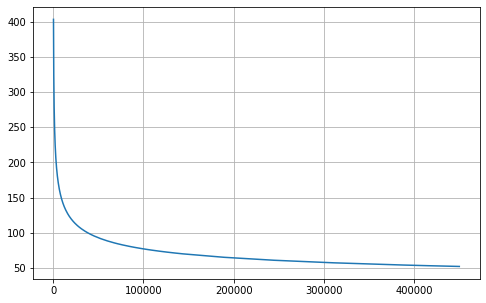

In [1]:
#Расчёт пластинчатого ТО (волны-sandia)
# рекуператор
import matplotlib.pyplot as pt
import numpy as n
import json, CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI as p
CP.set_config_string(CP.ALTERNATIVE_REFPROP_PATH, 'C:\\maximov\\REFPROP\\')
from scipy.optimize import root

#исходные данные:

T11 = 663.599
T21 = 60.2154
T12 = 83

T22 = 640.595
Q = 452413

G1 = 637.892
G2 = 543.18


P11=3000000
P21=30000000
P12 = P11
P22 = P21
Q=Q*1000

#Геометрия
delta = 0.002       #толщина металла
hc = 0.00094        #высота канала
wpl = 1             #ширина пластины
wc = wpl/1.254      #ширина проходного сечения
fprohc = wc*hc      #проходное сечение 1 пластины
dh =0.00109         #характерный размер
hpl = hc+delta      #высота пластины
lambdaw = 20        #теплопроводность металла

CO2 = 'REFPROP::CO2'
O2 = 'REFPROP::Oxygen' #!
H2O = 'REFPROP::WATER'
ro11 = p('D','T', T11+273.15, 'P', P11, CO2)
ro12 = p('D','T', T12+273.15, 'P', P12, CO2)
ro21 = p('D','T', T21+273.15, 'P', P21, CO2)
ro22 = p('D','T', T22+273.15, 'P', P22, CO2)
ro1 = (ro11+ro12)/2
ro2 = (ro21+ro22)/2
nu11 = p('V','T', T11+273.15, 'P', P11, CO2)/ro11
nu12 = p('V','T', T12+273.15, 'P', P12, CO2)/ro12
nu21 = p('V','T', T21+273.15, 'P', P21, CO2)/ro21
nu22 = p('V','T', T22+273.15, 'P', P22, CO2)/ro22
nu1 = (nu11+nu12)/2
nu2 = (nu21+nu22)/2
lambda11 = p('L','T', T11+273.15, 'P', P11, CO2)
lambda12 = p('L','T', T12+273.15, 'P', P12, CO2)
lambda21 = p('L','T', T21+273.15, 'P', P21, CO2)
lambda22 = p('L','T', T22+273.15, 'P', P22, CO2)
lambda1 = (lambda11+lambda12)/2
lambda2 = (lambda21+lambda22)/2
Pr11 = p('PRANDTL','T', T11+273.15, 'P', P11, CO2)
Pr12 = p('PRANDTL','T', T12+273.15, 'P', P12, CO2)
Pr21 = p('PRANDTL','T', T21+273.15, 'P', P21, CO2)
Pr22 = p('PRANDTL','T', T22+273.15, 'P', P22, CO2)
Pr1 = (Pr11+Pr12)/2
Pr2 = (Pr21+Pr22)/2

dTmax = T11 - T22
dTmin = T12 - T21
dT = (dTmax - dTmin) / (n.log(dTmax / dTmin))
##############################################


dP = n.zeros(100000)
Vv = n.zeros(100000)
i=0
for w1 in n.arange(0.01,200,0.005):
    Fproh1 = G1/(ro1*w1)
    Npl1 = round(Fproh1/fprohc)
    Npl2 = round(Npl1 /2)
    Nsumm = Npl1+Npl2
    Fproh2 = Npl2*fprohc
    w2 = G2/(ro2*Fproh2)

    Re1 = w1*dh/nu1
    Re2 = w2*dh/nu2
    Nu1 = 0.1740*Re1**0.593*Pr1**0.430
    Nu2 = 0.1740*Re2**0.593*Pr2**0.430
    f1 = 0.4545*Re1**-0.405
    f2 = 0.4545*Re2**-0.405
    alpha1 = Nu1*lambda1/dh
    alpha2 = Nu2*lambda2/dh
    
    #K = 1/((1/alpha1)+(delta/lambdaw)+(1/alpha2))
    #F = Q/(K*dT)
    #Fl = Nsumm*(1.905)/2
    #L = F/Fl
    
    KF = Q/dT
    def func(x):
        L=x
        a1 = 1/KF
        F1 = Npl1*L*(1.905)
        F2 = Npl2*L*(1.905)
        a2 = 1/(alpha1*F1)
        a3 = delta/(lambdaw*((F1+F2)/2))
        a4 = 1/(alpha2*F2)
        return a1-a2-a3-a4
    sol = root(func, 0.002)
    x=sol.x
    L=float(x)
    
    
    W = wpl
    H = hpl*Nsumm
    dP1 = f1*L/dh*ro1*w1**2/2
    dP2 = f2*L/dh*ro2*w2**2/2
    V=L*W*H
    if round(dP1/10000,1)==round(0.01*P11/10000,1):
        print('1%',w1,w2,dP1,dP2,L, Nsumm)
        print('+')
    if round(dP1/10000,1)==round(0.02*P11/10000,1):
        print('2%',w1,w2,dP1,dP2,L, Nsumm)
        print('+')
    if round(dP1/10000,1)==round(0.04*P11/10000,1):
        print('4%',w1,w2,dP1,dP2,L, Nsumm)
        print('+')
    if round(dP1/10000,1)==round(0.06*P11/10000,1):
        print('6%',w1,w2,dP1,dP2,L, Nsumm)
        print('+')
    if round(dP1/10000,1)==round(0.08*P11/10000,1):
        print('8%',w1,w2,dP1,dP2,L, Nsumm)
        print('+')
    if round(dP1/10000,1)==round(0.1*P11/10000,1):
        print('10%',w1,w2,dP1,dP2,L, Nsumm)
        print('+')
    dP[i] = dP1
    Vv[i]=V
    i=i+1
    if dP1>0.15*P11:
        break;

imax=i
x = [dP[i] for i in range(100,imax)]
y = [Vv[i] for i in range(100,imax)]
pt.figure(figsize=(8, 5))
pt.plot(x, y)
pt.grid(True)
#pt.ylim([0,100])
#pt.xlim([1000,2*10**5])
pt.show()